In [5]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap, grad, jit, random

import matplotlib
import matplotlib.pyplot as plt

import xarray as xr
import netCDF4 as nc
import os

from tqdm.notebook import tqdm
from tqdm.notebook import trange

In [6]:
## doesnt work right but this is the link
!wget https://huggingface.co/datasets/climateset/climateset/blob/main/outputs/CESM2.tar.gz

In [84]:

hist_hr = 'data/CESM2/historical/tas/100_km/mon/'
hist_lr = 'data/CESM2/historical/tas/250_km/mon/'
years = os.listdir(hist_hr)
tas_hr = []
tas_lr = []

for year in tqdm(years):
    hist_f = hist_hr + year + '/'
    hist_f = hist_f + os.listdir(hist_f)[0]
    
    hist = nc.Dataset(hist_f)
    tas_hr_t = np.asarray(hist['tas'])
    tas_hr_t = tas_hr_t - 273.15
    tas_hr_t = np.rot90(tas_hr_t, k = 2, axes = (1, 2))
    tas_hr_t = np.flip(tas_hr_t, axis = 2)
    
    hist_f = hist_lr + year + '/'
    hist_f = hist_f + os.listdir(hist_f)[0]
    
    hist = nc.Dataset(hist_f)
    tas_lr_t = np.asarray(hist['tas'])
    tas_lr_t = tas_lr_t - 273.15
    tas_lr_t = np.rot90(tas_lr_t, k = 2, axes = (1, 2))
    tas_lr_t = np.flip(tas_lr_t, axis = 2)

    tas_hr.append(tas_hr_t)
    tas_lr.append(tas_lr_t)

tas_hr = np.concat(tas_hr)
tas_lr = np.concat(tas_lr)

  0%|          | 0/165 [00:00<?, ?it/s]

In [90]:
tas_lr = jax.image.resize(tas_lr, (tas_lr.shape[0], 24, 36), method = 'bicubic')

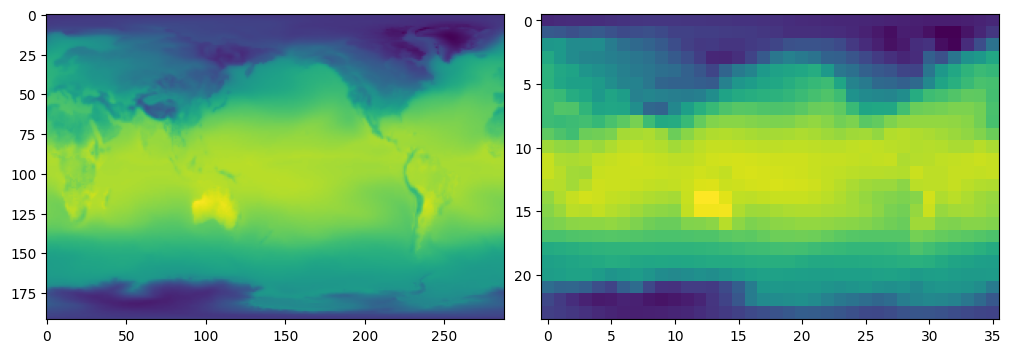

In [92]:
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (10, 4))

ax[0].imshow(tas_hr[0])
ax[1].imshow(tas_lr[0])
plt.show()

In [94]:
np.save('./data/cesm_tas_hr.npy', tas_hr)
np.save('./data/cesm_tas_lr.npy', tas_lr)

In [3]:
ntrain = 52000
nval = 20000
ntest = 20000

train = era5['temperature'][0:ntrain,-1]
val = era5['temperature'][ntrain:(ntrain+nval),-1]
test = era5['temperature'][(ntrain+nval):(ntrain+nval+ntest),-1]

In [4]:
t_train = era5['time'][0:ntrain]
t_val = era5['time'][ntrain:(ntrain+nval)]
t_test = era5['time'][(ntrain+nval):(ntrain+nval+ntest)]

dtrain = np.array(train)
dval = np.array(val)
dtest = np.array(test)

dtrain = dtrain - 273.15
dval = dval - 273.15
dtest = dtest - 273.15

In [5]:
dtrain = np.moveaxis(dtrain, 1, 2)
dtrain = np.rot90(dtrain, k = 2, axes = (1, 2))
dtrain = np.flip(dtrain, axis = 2)

dval = np.moveaxis(dval, 1, 2)
dval = np.rot90(dval, k = 2, axes = (1, 2))
dval = np.flip(dval, axis = 2)

dtest = np.moveaxis(dtest, 1, 2)
dtest = np.rot90(dtest, k = 2, axes = (1, 2))
dtest = np.flip(dtest, axis = 2)

In [6]:
train_day = np.array(train['time']["time.dayofyear"])
val_day = np.array(val['time']["time.dayofyear"])
test_day = np.array(test['time']["time.dayofyear"])

## anomalize
dmeans = [np.mean(dtrain[train_day == i]) for i in range(1, 367)]

for i in trange(len(dtrain), leave = False):
  dtrain[i] = dtrain[i] - dmeans[train_day[i]-1]

for i in trange(len(dval), leave = False):
  dval[i] = dval[i] - dmeans[val_day[i]-1]

for i in trange(len(dtest), leave = False):
  dtest[i] = dtest[i] - dmeans[test_day[i]-1]

  0%|          | 0/52000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [7]:
## detrend
t = np.linspace(0, 1, ntrain+nval+ntest)
t1 = t[:ntrain]
t2 = t[ntrain:(ntrain+nval)]
t3 = t[(ntrain+nval):(ntrain+nval+ntest)]
d = np.mean(dtrain, axis = (1, 2))

beta = np.polyfit(t1, d, 1)
dtrain = dtrain - np.polyval(beta, t[:ntrain])[:,None,None]
dval = dval - np.polyval(beta, t2)[:,None,None]
dtest = dtest - np.polyval(beta, t3)[:,None,None]

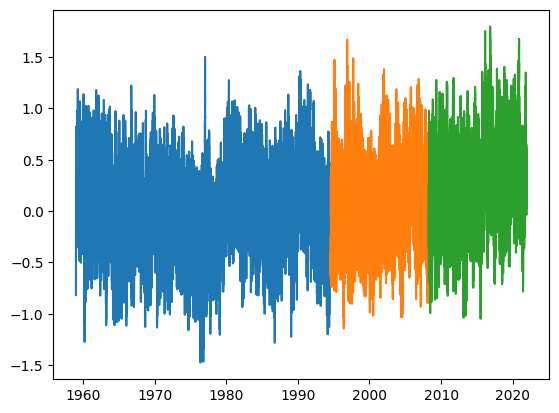

In [8]:
plt.plot(t_train, np.mean(dtrain, axis = (1, 2)))
plt.plot(t_val, np.mean(dval, axis = (1, 2)))
plt.plot(t_test, np.mean(dtest, axis = (1, 2)))

In [9]:
np.save('./data/era5_train_small.npy', dtrain)
np.save('./data/era5_val_small.npy', dval)
np.save('./data/era5_test_small.npy', dtest)